<a href="https://colab.research.google.com/github/sehan25/ESAA-2022-1/blob/main/Assignment/0415_Python_Machine_Learning_p147-174.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAPTER 03. 평가

- 성능 평가 지표(Evaluation Metric)는 일반적으로 모델이 분류나 회귀냐에 따라 여러 종류로 나뉜다.
    - 회귀의 경우 대부분 실제값과 예측값의 오차 평균값에 기반한다.
    - 분류의 경우 일반적으로는 실제 결과 데이터와 예측 결과 데이터가 얼마나 정확하고 오류가 적게 발생하는가에 기반하지만, 단순히 이러한 정확도만 가지고 판단했다가는 잘못된 평가 결과에 빠질 수 있다.
- 분류의 성능 평가 지표 (특히 이진 분류에서 더욱 중요하게 강조하는 지표)
    - 정확도(Accuracy)
    - 오차 행렬(Confusion Matrix)
    - 정밀도(Precision)
    - 재현율(Recall)
    - F1 스코어
    - ROC AUC
- 분류는 결정 클래스 값 종류의 유형에 따라 긍정/부정과 같은 2개의 결괏값만을 가지는 이진 분류와 여러개의 결정 클래스 값을 가지는 멀티 분류로 나눌 수 있다.

## **01. 정확도**
---

: **실제 데이터에서 예측 데이터가 얼마나 같은지**를 판단하는 지표

 $$정확도(Accuracy) = \frac{예측 결과가 동일한 데이터 건수}{전체 예측 데이터 건수}$$


- 직관적으로 모델 예측 성능을 나타내는 평가 지표이지만,  
이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않는다.

In [1]:
import numpy as np
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass

    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros( (X.shape[0], 1) )
        for i in range (X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [2]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
from google.colab import drive
drive.mount('/content/drive')
titanic_df = pd.read_csv('/content/drive/MyDrive/ESAA/data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행.
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Mounted at /content/drive
Dummy Classifier의 정확도는: 0.7877


- 이렇게 단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도 결과는 꽤 높은 수치가 나올 수 있기에 정확도를 평가 지표로 사용할 때는 매우 신중해야 한다.
    - 특히 정확도는 **불균형한**(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아니다.

- 예제) 유명한 MNIST 데이터 세트를 변환해 불균형한 데이터 세트로 만든 뒤에 정확도 지표 적용 시 어떤 문제가 발생할 수 있는지 살펴보기
    - 원래는 레이블 값이 0부터 9까지 있는 멀티 레이블 분류를 위한 것인데, 이를 레이블 값이 7인 것만 True, 나머지 값은 모두 False로 변환해 이진 분류로 바꿈  
    => 즉, 전체 데이터의 10%만 True, 나머지 90%는 False인 불균형한 데이터 세트로 변형하는 것
    - 이렇게 불균형한 데이터 세트에 모든 데이터를 False, 즉 0으로 예측하는 classifier를 이용해 정확도를 측정하면 약 90%에 가까운 예측 정확도를 나타냄

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력갑승로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros( (len(X), 1), dtype=bool )
    
# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환.
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [5]:
# 불균형한 레이블 데이터 분포도 확인. 
print('레이블 테스트 세트 크기: ', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train , y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test , fakepred)))

레이블 테스트 세트 크기:  (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


- **정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안 된다.**
    - 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용해야 한다.

## **02. 오차 행렬**
---
: 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지도 함께 보여주는 지표  
=> 즉, **이진 분류의 예측 오류가 얼마인지**와 더불어 **어떠한 유형의 예측 오류가 발생하고 있는지**를 함께 나타내는 지표

- 다음과 같은 4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지를 나타낸다.


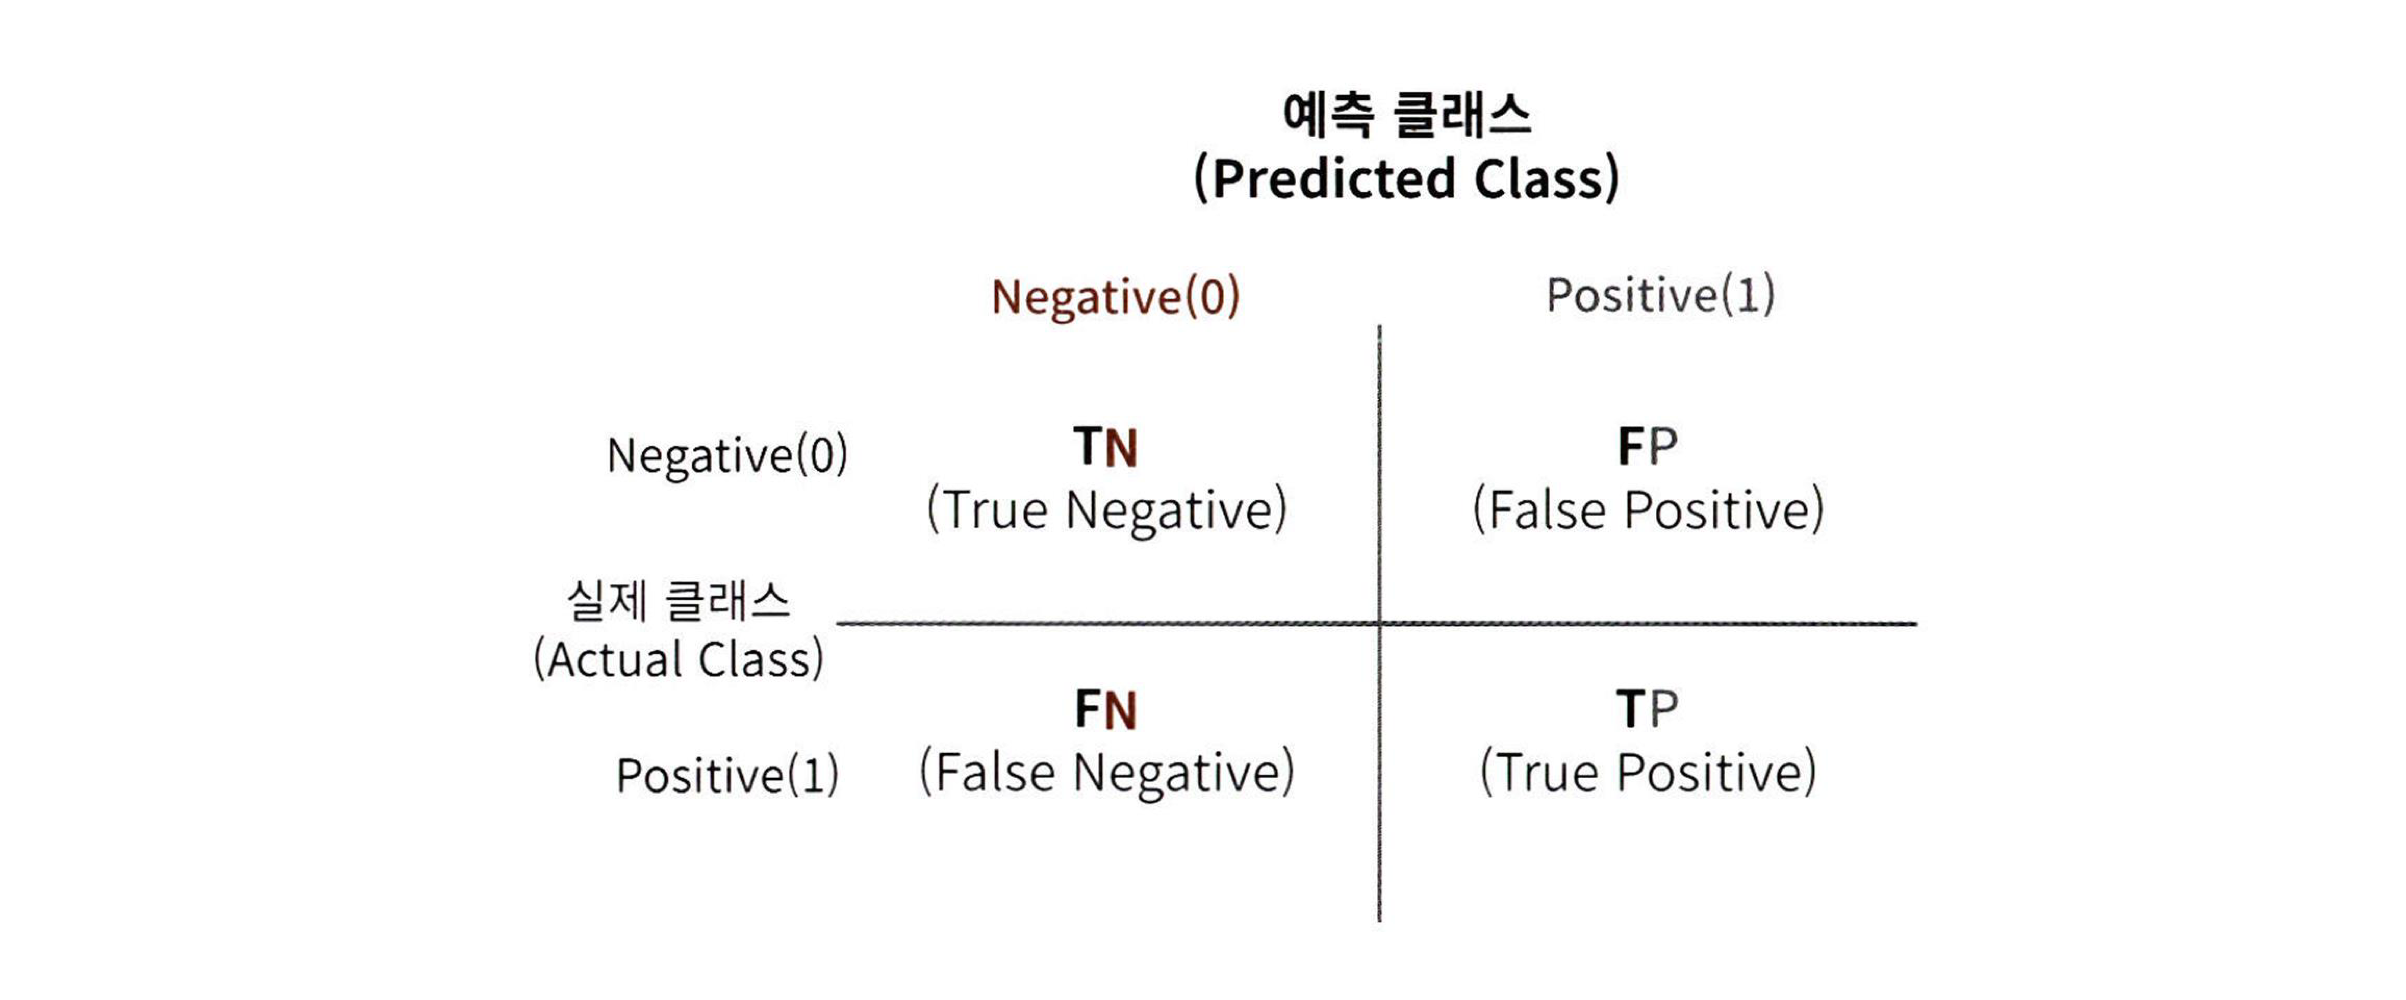

- TN, FP, FN, TP는 예측 클래스와 실제 클래스의 Positive 결정 값(값 1)과 Negative 결정 값(값 0)의 결합에 따라 결정된다.
    - **TN**: 예측값을 Negative 값 0으로 예측했고 실제 값 역시 Negative 값 0
    - **FP**: 예측값을 Positive 값 1로 예측했는데 실제 값은 Negative 값 0
    - **FN**: 예측값을 Negative 값 0으로 예측했는데 실제 값은 Positive 값 1
    - **TP**: 예측값을 Positive 값 1로 예측했는데 실제 값 역시 Positive 값 1

In [6]:
from sklearn.metrics import confusion_matrix

# 앞에서 예측했던 결과인 fakepred와 실제 결과인 y_test의 Confusion Matrix 출력
confusion_matrix(y_test , fakepred)

array([[405,   0],
       [ 45,   0]])

- TP, TN, FP, TN 값을 조합해 Classifier의 성능을 측정할 수 있는 주요 지표인 정확도(Accuracy), 정밀도(Precision), 재현율(Recall) 값을 알 수 있다.

- 정확도(Accuracy)

    **`정확도 = 예측 결과와 실제 값이 동일한 건수 / 전체 데이터 수 = (TN + TP) / (TN + FP+ FN + TP)`**

    - 예측값과 실제 값이 얼마나 동일한가에 대한 비율만으로 결정됨  
    => 즉, 오차 행렬에서 True에 해당하는 값인 **TN과 TP에 좌우**됨
    - 일반적으로 불균형한 레이블 클래스를 가지는 이진 분류 모델에서는 많은 데이터 중에서 중점적으로 찾아야 하는 매우 적은 수의 결과값에 Positive를 설정해 1값을 부여하고, 그렇지 않은 경우는 Negative로 0값을 부여하는 경우가 많음
        - 이로 인해 불균형한 이진 분류 데이터 세트에서는 Positive 데이터 건수가 매우 작기 때문에 데이터에 기반한 ML 알고리즘은 Positive보다는 Negative로 예측 정확도가 높아지는 경향이 발생함
    - 결과적으로 정확도 지표는 **비대칭한 데이터 세트에서 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는** 수치적인 판단 오류를 일으키게 됨

## **03. 정밀도와 재현율**
---
Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표

**`정밀도 = TP / (FP + TP)`**  
**`재현율 = TP / (FN + TP)`**

- **정밀도**: **예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율**
    - 분모 FP + TP는 예측을 Positive로 한 모든 데이터 건수  
    분자 TP는 예측과 실제 값이 Positive로 일치한 데이터 건수
    - Positivie 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 **양성 예측도**라고도 불림

- **재현율**: **실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율**
    - 분모 FN + TP는 실제 값이 Positive인 모든 데이터 건수  
    분자 TP는 예측과 실제 값이 Positive로 일치한 데이터 건수
    - **민감도(Sensitivity)** 또는 **TRR(True Positive Rate)**라고도 불림

- 정밀도와 재현율 지표 중에 이진 분류 모델의 업무 특성에 따라서 특정 평가 지표가 더 중요한 지표로 간주될 수 있다.
    - 재현율이 상대적으로 더 중요한 지표인 경우는 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우  예) *암 판단 모델, 금융 사기 적발 모델*
    - 정밀도가 상대적으로 더 중요한 지표인 경우는 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우  예) *스팸메일 여부 판단 모델*
    
- **재현율과 정밀도 모두 TP를 높이는 데 동일하게 초점**을 맞추지만, **재현율은 FN(실제 Positive, 예측 Negative)를 낮추는 데, 정밀도는 FP를 낮추는 데 초점**을 맞춘다.
- **가장 좋은 성능 평가는 재현율과 정밀도 모두 높은 수치**를 얻는 것이다.

In [7]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [8]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할. 
titanic_df = pd.read_csv('/content/drive/MyDrive/ESAA/data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


> ### 정밀도/재현율 트레이드오프
> ---

- 분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다.  
하지만 **정밀도와 재현율은 상호 보완적인 평가 지표**이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽다.
- 사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블(Label, 결정 클래스 값)에 속하는지를 계산하기 위해 먼저 개별 레이블별로 결정 확률을 구한다. 그리고 예측 확률이 큰 레이블 값으로 예측하게 된다.
    - 일반적으로 이진 분류에서는 임곗값을 0.5, 즉 50%로 정하고 이 기준 값보다 확률이 크면 Positive, 작으면 Negative로 결정한다.
- 사이킷런은 개별 데이터별로 예측 확률을 반환하는 메서드인 **`predict_proba()`**를 제공한다.
    - 학습이 완료된 사이킷런 Classifier 객체에서 호출 가능
    - 입력 파라미터
        - `predict()` 메서드와 동일하게 보통 테스트 Feature 데이터 세트
    - 반환 값
        - 각 열은 개별 클래스의 예측 확률
        - 이진 분류에서 반환되는 ndarray에서 첫 번째 칼럼은 클래스 값 0에 대한 예측 확률, 두 번째 칼럼은 클래스 값 1에 대한 예측 확률 -> 첫 번째 칼럼 값과 두 번째 칼럼 값을 더하면 1이 됨

In [9]:
pred_proba = lr_clf.predict_proba(X_test)
pred  = lr_clf.predict(X_test)
print('pred_proba()결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba()결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46191519 0.53808481]
 [0.878675   0.121325  ]
 [0.87716185 0.12283815]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46191519 0.53808481 1.        ]
 [0.878675   0.121325   0.        ]
 [0.87716185 0.12283815 0.        ]]


- 사실 `predict()` 메서드는 `predict_proba()` 메서드에 기반해 생성된 API이다.
    - `predict()`: `predict_proba()` 호출 결과로 반환된 배열에서 분류 결정 임계값보다 큰 값이 들어 있는 칼럼의 위치(첫 번째 칼럼 또는 두 번째 칼럼)를 받아서 최종적으로 예측 클래스를 결정하는 API
    - 구현을 위해 사이킷런의 Binarizer 클래스 이용

In [10]:
## 예제

from sklearn.preprocessing import Binarizer

X = [[ 1, -1,  2],
     [ 2,  0,  0],
     [ 0,  1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)                     
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [11]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.  
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 컬럼, 즉 Positive 클래스 칼럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


- 위 의사코드로 계산된 평가 지표는 앞 예제의 타이타닉 데이터로 학습된 로지스틱 회귀 Classifier 객체에서 호출된 `predict()`로 계산된 지표 값과 정확히 같다.

In [12]:
## 분류 결정 임곗값 낮춰보기

# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤  
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test , custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


- **분류 결정 임곗값이 낮아질수록 재현율 값은 올라가고 정밀도는 떨어진다.**
    - 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이기 때문
    - 양성 예측을 많이 하다 보니 실제 양성을 음성으로 예측하는 횟수가 상대적으로 줄어들기 때문

In [13]:
## 임곗값을 0.4부터 0.6까지 0.05씩 증가시키며 평가 지표를 조사

# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(Y_test, pred_proba_c1, thresholds):
    # thresholds list객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print("임계값:", custom_threshold)
        get_clf_eval(Y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임계값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임계값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임계값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임계값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


- 사이킷런은 이와 유사한 **`precision_recall_curve()`** API를 제공한다.
    - 입력 파라미터
        - `y_true`: 실제 클래스값 배열 (배열 크기=[데이터 건수])
        - `probas_pred`: Positive 칼럼의 예측 확률 배열 (배열 크기=[데이터 건수])
    - 반환 값
        - 정밀도: 임곗값별 정밀도 값을 배열로 반환 (일반적으로 0.11~0.95 정도의 임곗값)
        - 재현율: 임곗값별 재현율 값을 배열로 반환
    - **임곗값이 증가할수록 정밀값은 동시에 높아지나 재현율 값은 낮아짐**을 알 수 있음

In [14]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

# 실제값 데이터 세트과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


- `precision_recall_curve()` API는 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태의 그래프로 시각화하는 데 이용할 수 있다.

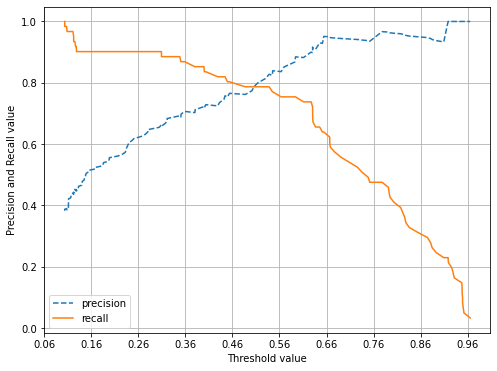

In [15]:
## precision_recall_curve() API 이용해 정밀도와 재현율 곡선 시각화

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

> ### 정밀도와 재현율의 맹점
> ---

- 정밀도가 100%가 되는 방법
    - 확실히 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측함
- 재현율이 100%가 되는 방법
    - 모든 환자를 Positive로 예측하면 됨
- 정밀도 또는 재현율 중 하나만 스코어가 좋고 다른 하나는 스코어가 나쁜 분류는 성능이 좋지 않은 분류로 간주할 수 있다.
- 정밀도와 재현율의 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요하다.

## **04. F1 스코어**
---
: **정밀도와 재현율을 결합한 지표**

$$F1 = \frac{2}{\frac{1}{recall}+\frac{1}{precision}} = 2* \frac{precision * recall}{precision + recall}$$

- 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타날 때 상대적으로 높은 값을 가진다.
- 사이킷런은 F1 스코어를 구하기 위해 **`f1_score()`**라는 API를 제공한다.

In [16]:
from sklearn.metrics import f1_score 
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [17]:
## 타이타닉 생존자 예측에서 임곗값을 변화시키면서 F1 스코어를 포함한 평가 지표 구하기

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)

    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)

    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.40, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1: 0.7727
임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840
임계값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805
임계값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931
임계값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036


## **05. ROC 곡선과 AUC**
---
**ROC(Receiver Operation Characteristic Curve)**  
: **FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지**를 나타내는 곡선

- 일반적으로 의학 분야에서 많이 사용되지만, 머신러닝의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표이기도 하다.
- FPR을 X축으로, TPR을 Y축으로 잡아 FPR의 변화에 따른 TPR의 변화가 곡선 형태로 나타난다.
    - **민감도 또는 재현율 (TPR)**: 실제값 Positive(양성)가 정확히 예측돼야 하는 수준  
    (질병이 있는 사람이 질병이 있는 것으로 양성 판정)
$$TPR = \frac{TP}{FN + TP}$$
    - **특이성 (TNR)**: 실제값 Negative(음성)가 정확히 예측돼야 하는 수준  
    (질병이 없는 건강한 사람이 질병이 없는 것으로 음성 판정)
    $$TNR = \frac{TN}{FP + TN}$$
    - FPR(False Positive Rate):
    $$FPR = \frac{FP}{FP + TN} = 1 - TNR = 1 - 특이성$$
- **ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지는 것이며, 멀어질수록 성능이 뛰어난 것**이다.
- ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화 값을 구한다,
    - FPR을 0으로 만들려면 임곗값을 1로 지정하면 됨
        - Positive 예측 기준이 매우 높기 때문에 분류기(Classifier)가 임곗값보다 높은 확률을 가진 데이터를 Positive로 예측할 수 없어 FP 값이 0이 되고 FPR은 0이 됨
    - FPR을 1으로 만들려면 임곗값을 0으로 지정하면 됨
        - Positive 확률 기준이 너무 낮아서 다 Positive로 예측하고 아예 Negative 예측이 없어 TN 값은 0이 되고 FPR 값은 1이 됨

- 사이킷런은 ROC 곡선을 구하기 위해 **`roc_curve()`** API를 제공한다.
    - 입력 파라미터
        - `y_true`: 실제 클래스 값 array (array shape = [데이터 건수])
        - `y_score`: predict_proba()의 반환 값 array에서 Positive 칼럼의 예측 확률이 보통 사요됨. array_shape = [n_samples]
    - 반환 값
        - fpr: fpr 값을 array로 반환
        - tpr: tpr 값을 array로 반환
        - thresholds: threshold 값 array

In [18]:
## roc_curve() API를 이용해 타이타닉 생존자 예측 모델의 FPR, TPR, 임곗값 구하기

from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 Step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


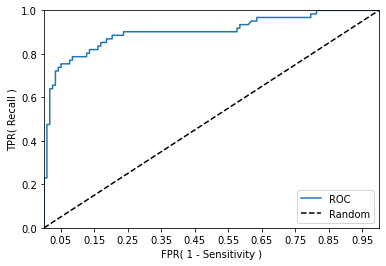

In [19]:
## FPR의 변화에 따른 TPR의 변화를 ROC 곡선으로 시각화

def roc_curve_plot(y_test , pred_proba_c1):

    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)

    # ROC 곡선을 그래프 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')

    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()

roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

- 일반적으로 **ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는 데 이용**하며 **분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값**으로 결정한다.
- **AUC(Area Under Curve): ROC 곡선 밑의 면적을 구한 것**
    - 일반적으로 **1에 가까울수록 좋은 수치**
    - AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건임
        - 가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할수록 직사각형에 가까운 곡선이 되어 면적이 1에 가까워지는 좋은 ROC AUC 성능 수치를 얻게 됨
    - 가운데 대각선 직선은 랜덤 수준의 이진 분류 AUC 값으로 0.5이며 보통의 분류는 0.5 이상의 AUC 값을 가짐

In [20]:
from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8341


In [21]:
## get_clf_eval() 함수에 ROC AUC값 측정하는 로직 추가해
## 정확도, 정밀도, F1 스코어, ROC AUC 값 모두 출력하게 만들기

def get_clf_eval(y_test, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)

    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))